Alyssa Hajj Assaf

Paul Villedieu

Yu Chen




## Fetching Data

In [ ]:
!pip install biopython
!wget https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/AMP_20190407.fa
!wget https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/non_AMP_20190413.fa
!wget https://raw.githubusercontent.com/tlawrence3/amPEPpy/master/training_data/M_model_train_AMP_sequence.numbered.fasta
!wget https://raw.githubusercontent.com/tlawrence3/amPEPpy/master/training_data/M_model_train_nonAMP_sequence.numbered.fasta

     |████████████████████████████████| 2.3MB 20.2MB/s 
--2021-04-30 22:27:40--  https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/AMP_20190407.fa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166037 (162K) [text/plain]
Saving to: ‘AMP_20190407.fa’

AMP_20190407.fa     100%[===================>] 162.15K  --.-KB/s    in 0.002s  

2021-04-30 22:27:40 (71.5 MB/s) - ‘AMP_20190407.fa’ saved [166037/166037]

--2021-04-30 22:27:40--  https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/non_AMP_20190413.fa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, a

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier

from Bio import SeqIO

from pprint import pprint

## Preprocessing

In [ ]:
def fasta_to_str_set(name):
  return {str(rec.seq) for rec in SeqIO.parse(name, 'fasta')}

In [ ]:
positive_examples = fasta_to_str_set('AMP_20190407.fa').union(fasta_to_str_set('M_model_train_AMP_sequence.numbered.fasta'))
negative_examples = fasta_to_str_set('non_AMP_20190413.fa').union(fasta_to_str_set('M_model_train_nonAMP_sequence.numbered.fasta'))

Our feature extraction model is based on the 6-letter exchange group information with 2-gram vocabulary for protein extraction. The theory for this prodecure can be found here: https://www.hindawi.com/journals/bmri/2014/103054/?fbclid=IwAR1MEk3D2IE6AB_kLpdeiuqepJ2uziKR4ZS9z2cNJOfKe-7fgqQMqtSRVi8 In section 2. Feature Extraction.

**Feature extration explanation**

`six_letter_exchange`: A commonly used feature extraction method for protein sequence is the 6-letter exchange group. The six combinations from the whole set of amino acid {A,C,D,E,... Y} is formed as: A={H,R,K}, B={D,E,N,Q}, C={C}, D={S,T,P,A,G}, E={M,I,L,V}, F={F,Y,W}. Thus, this reduced the size of our initial vocabulary 20 amino acid to 6 exchange group : {A,B,C, D, E, F}. Thus, this function takes as input the original protein sequences labeled witht the 20 amino acid feature letters and transform it into a 6-letter exchange sequence of the same lenght. 

`two_gram_vocab` : A protein sequence is a various combination of 20 amino acids. When the sequence is transformed by `six_letter_exchange` function, it becomes a various combination of 6 exchange group. Rather than using the frequency of each exchange group as feature vectors, we use the 2-gram feature frequency. Namely, we look at the frequency of the following combinations : {(AA),(AB),(AC), ..., (FF)} which is of size $6^2$ . Thus, this sequence takes as input the vocabulary we want to extract and generates combinations of 2 letters with the whole vocabulary, in dictionary format. 

`feature_extraction`: this function takes as input our matrix of 6-letter transformed protein sequences, our own initialized vocabulary and uses TF-iDF to extract the frequencies of each features of our vocabulary. 
Eg. A protein sequence VAAGTVAGT becomes EDDDDEDDD and the 2-gram feature vector of frequencies is [(DE,1),(ED,2),(DD,5), (AA,0), (AB,0),...(FF,0)] 
 

In [ ]:
def two_gram_vocab(letters):
  #initialize our own vocabulary for TF-IDF, letters needs to be of the form ["a","b","c",...etc]
  #our vocal final would be = [(AA,0),(AB,1),(AC,2),...(FF,35)]
  vocab={}
  index=0
  for i in letters:
    for j in letters:
      vocab[f"{i+j}"]=index
      index+=1
  return vocab

def six_letter_exchange(positive_examples,negative_examples):
  #This feature extraction is based on the 6-letter exchange group information for protein feature extraction
  #Concretly A={H,R,K}, B={D,E,N,Q}, C={C}, D={S,T,P,A,G}, E={M,I,L,V}, F={F,Y,W}

  #convert input sequences into a 6-letter exchange group information
  LE_6 = {"B":['D','E','N','Q'], "C":['C'], "D":['S','T','P','A','G'],"A":['H', 'R', 'K'], "E":['M','I','L','V'], "F":['F','Y','W']}
  #the order of the dictionary is such that we don't change a letter that was already changed 
  pos_6=positive_examples
  neg_6=negative_examples
  for key, value in LE_6.items():
    for i in value:
      for id in range(len(pos_6)):
        pos_6[id]=str(pos_6[id]).replace(i,key)
      for id in range(len(neg_6)):
        neg_6[id]=str(neg_6[id]).replace(i,key)
     
  return pos_6,neg_6

def feature_extraction(pos_eg,neg_eg,vocab):
  vectorizer = TfidfVectorizer(analyzer='char_wb',ngram_range=(2,2),use_idf=False,vocabulary=vocab)
  #create a matrix of size =(#example X #feature), where feature={AA,AB,AC,...,FF}. The entries of the array contains the 
  #frequencies of the feature
  pos_response= vectorizer.fit_transform(pos_eg).todense()
  neg_response= vectorizer.fit_transform(neg_eg).todense()
  return pos_response,neg_response
                            

In [ ]:
#Initialize the vocab, transform data into a 6-letter-exchange group information
vocab= two_gram_vocab(["a","b","c","d","e","f"])
pos_eg,neg_eg = six_letter_exchange(list(positive_examples),list(negative_examples))

#len_pos,len_neg= get_sequence_length(pos_eg,neg_eg)
pos_6,neg_6 = feature_extraction(pos_eg,neg_eg,vocab)

#create the labels. Positives sequences (AMP) are 0. Negative sequences (non-AMP) are 1
#append both labels and feature matrix of the 2 type
labels=np.append(np.zeros((pos_6.shape[0])),np.ones((neg_6.shape[0])))
data= np.append(pos_6, neg_6, axis=0)

#Divide the set in train/val/test
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

## Classifiers

### SVM

SVM is a supervised machine learning classification algorithm dealing with linearly seperable data. SVM finds the hyperplane that seperates the data with maximum margin. 

Finding the optimal hyperplane $H_{W,b}$ : maximize the margin
$argmax_{W,b}\{\textbf{min } d(x_i, H_{W,b})\}$

Where the distance from point x to the Hyperplane
$d(x, H_{W,b}) = |\frac{<W,x>+b}{\|W\|}|$

In [ ]:
class SVM:
  def __init__(self):
    self.svc = make_pipeline(StandardScaler(), SVC(random_state=0))

  def train(self, X_train, y_train):
    self.svc.fit(X_train, y_train)

  def evaluate(self, X_test, y_test):
    y_pred = self.svc.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print('Balanced accuracy on test set = {:0.2f}'.format(bal_acc))
    print('Confusion Matrix:')
    plot_confusion_matrix(estimator= self.svc, X=X_test, y_true=y_test, normalize='true')
    plt.show()

  def load_params(self, params):
    self.svc.set_params(**best_params)

  def dump_params(self):
    self.scv.get_params()

  def randomSearchCV(self, X_train, y_train, n_iter, cv=3 ):
    distribution = dict(svc__C=np.arange(1,15), svc__degree=np.arange(2,7),
                        svc__kernel=['linear','poly','rbf', 'sigmoid'],
                        svc__shrinking=[True,False], svc__class_weight=['balanced', None],
                        svc__coef0 = np.arange(1,5,0.5))
    
    svc_random = RandomizedSearchCV(estimator=self.svc, param_distributions= distribution,
                                    scoring='balanced_accuracy', cv=cv, verbose=2, 
                                    random_state=0, n_jobs = -1, n_iter=n_iter)
    
    svc_random.fit(X_train, y_train)
    self.svc = svc_random.best_estimator_

  

Prior to best parameter search:
Balanced accuracy on test set = 0.78
Confusion Matrix:


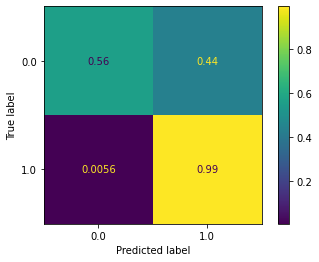

In [ ]:
svm = SVM()
svm.train(X_train, y_train)
print('Prior to best parameter search:')
svm.evaluate(X_test, y_test)


With RandomizedSearchCV, we obtain a optimal set of SVM parameters for our data set:

{'svc__shrinking': True, 'svc__kernel': 'rbf', 'svc__degree': 5, 'svc__coef0': 4.0, 'svc__class_weight'='balanced','svc__C': 7}

With optimal parameters:
Balanced accuracy on test set = 0.86
Confusion Matrix:


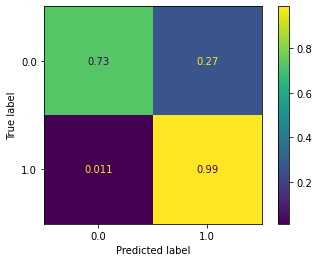

In [ ]:
best_params ={'svc__shrinking': True, 'svc__kernel': 'rbf', 'svc__degree': 5,
              'svc__coef0': 4.0, 'svc__class_weight':'balanced','svc__C': 7}
svm.load_params(best_params)
svm.train(X_train, y_train)
print('With optimal parameters:')
svm.evaluate(X_test, y_test)

One of the most challenging aspect of the AMP/non-AMP data set was the important difference between the number of AMP sequences and non-AMP sequences. Our support vector machine model tries to accomodate for this difference by using a balanced accuracy evaluation on the optimal parameter search, and a balanced class weight for the SVM margin. The use of a confusion matrix as metric evaluation was motivated by our interest in decreasing the rate of misclassification of AMP sequences, since AMP classification accuracy is more sensible to parameter changes. Thus, we can observed in the first and second confusion matrix for SVM that the rate of classification and misclassification for non-AMP sequences remain stable despite the change in SVM parameters. On the other hand, we observe an improvement for AMP classification after performing `randomSearchCV`. Despite this improvement, there remains a significant difference between the classification accuracy of AMP vs non-AMP for this model.

### Random Forest

Random Forest algorithms are an evolution of traditional decision trees. This evolution is marked by the addition of methods related to Ensemble Learning. Random Forests are composed of several decision trees trained on different parts of the training dataset. The prediction takes place thanks to a vote made by the prediction of each tree of the ensemble.
This method keeps some of the advantages of decision trees such as their ease of execution and their high interpretability. It also reduces the generalization problems of these simple methods that fail to make accurate predictions on unseen examples.

In [ ]:
class RandomForest:
    def __init__(self):
        self.rf = RandomForestClassifier(n_estimators=100, random_state=0)
    
    def train(self, X_train, y_train):
        self.rf.fit(X_train, y_train)
        
    def evaluate(self, X_test, y_test):
        y_pred = self.rf.predict(X_test)
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        print('Balanced accuracy on test set = {:0.2f}'.format(bal_acc))
        print('Confusion Matrix:')
        plot_confusion_matrix(estimator=self.rf, X=X_test, y_true=y_test, normalize='true')
        plt.show()
        
    def load_params(self, params):
        self.rf.set_params(**best_params)
        
    def dump_params(self):
        self.rf.get_params()
        
    def randomSearchCV(self, X_train, y_train, random_grid, n_iter=10, cv=3):
        rf_random = RandomizedSearchCV(
            estimator = self.rf, param_distributions=random_grid,
            scoring='balanced_accuracy', n_iter=n_iter, cv=cv,
            verbose=2, random_state=0, n_jobs = -1
        )
        rf_random.fit(X_train, y_train)
        self.rf = rf_random.best_estimator_

Base random forest:
Balanced accuracy on test set = 0.76
Confusion Matrix:


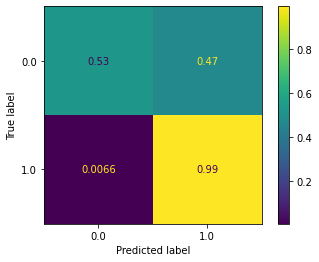

In [ ]:
rf = RandomForest()
rf.train(X_train, y_train)
print('Base random forest:')
rf.evaluate(X_test, y_test)

Thanks to `rf.randomSearchCV`, we found an optimal set of parameters:
```python
{'n_estimators': 1033,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'max_leaf_nodes': 150,
 'max_features': 'auto',
 'max_depth': 30,
 'criterion': 'entropy',
 'class_weight': 'balanced_subsample',
 'bootstrap': False}
```

Optimal random forest:
Balanced accuracy on test set = 0.93
Confusion Matrix:


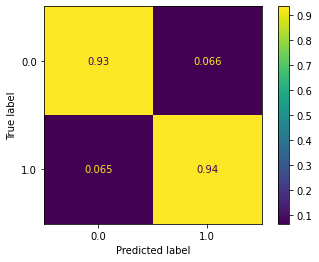

In [ ]:
best_params = {'n_estimators': 1033,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'max_leaf_nodes': 150,
 'max_features': 'auto',
 'max_depth': 30,
 'criterion': 'entropy',
 'class_weight': 'balanced_subsample',
 'bootstrap': False}

rf.load_params(best_params)
rf.train(X_train, y_train)
print('Optimal random forest:')
rf.evaluate(X_test, y_test)

For this part related to the Random Forest, we used the same training tools as for the SVM part. The `randomSearchCV` allowed us to optimize the hyper-parameters of the classifier and thus obtain significantly better results than those obtained with the default hyper-parameters. As the dataset is the same, we have chosen to use once again the balance-accuracy as a comparison metric in our cross-validation system.

### Neural Network

Neural Network is another machine learning architecture that is very powerful. It passes the inputs through several hidden layers of neurons. At each layer, the neurons will transform the input using the activation function, bias and weights. The weights are fine-tuned at each epoch in order to minimize the loss function. The outputs are calculated using a forward pas, and the gradients can be computed using backward propagation in order to find the optimal weights and biases that generate local minima. A single neuron is shown in the figure below: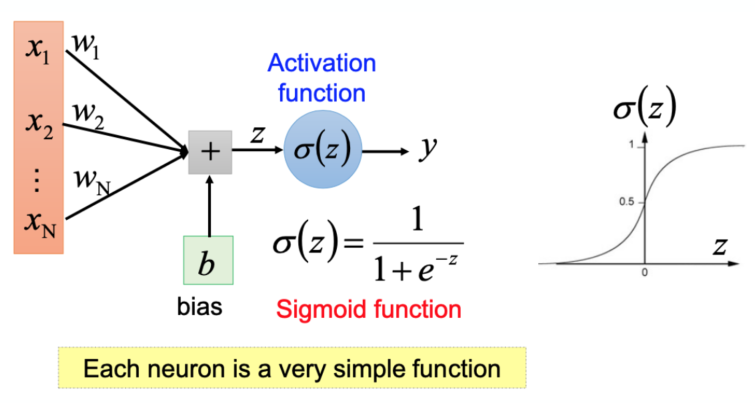

A complete deep neural network is shown:
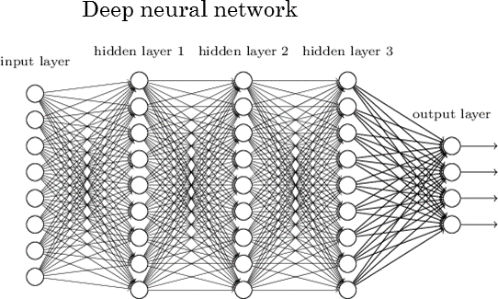

There are several type of activation functions such as RELU, tanh, etc.

The loss function for this case is the cross-entropy loss in binary classification.


$$
  L(y,\hat{y}) = -(y \ln(\hat{y}) + (1-y) \ln(1-\hat{y}))
$$

Where $\hat{y}$ is the prediction, and y is the true label.

In [ ]:
class NeuralNetwork:
    def __init__(self):
        self.NN = MLPClassifier(random_state=0)
    
    def train(self, X_train, y_train):
        self.NN.fit(X_train, y_train)
        
    def evaluate(self, X_test, y_test):
        y_pred = self.NN.predict(X_test)
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        print('Balanced accuracy on test set = {:0.2f}'.format(bal_acc))
        print('Confusion Matrix:')
        plot_confusion_matrix(estimator=self.NN, X=X_test, y_true=y_test, normalize='true')
        plt.show()
        
    def load_params(self, params):
        self.NN.set_params(**best_params)
        
    def dump_params(self):
        self.NN.get_params()
        
    def randomSearchCV(self, X_train, y_train, random_grid, n_iter=10, cv=3):
        NN_random = RandomizedSearchCV(
            estimator = self.NN, param_distributions=random_grid,
            scoring='balanced_accuracy', n_iter=n_iter, cv=cv,
            verbose=2, random_state=0, n_jobs = -1
        )
        NN_random.fit(X_train, y_train)
        self.NN = NN_random.best_estimator_
        print(NN_random.best_estimator_)

Base Neural Network is:
Balanced accuracy on test set = 0.76
Confusion Matrix:


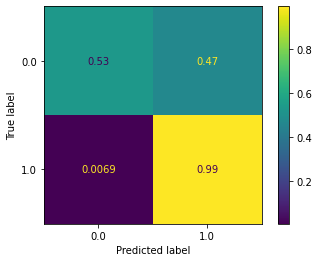

In [ ]:
NN = NeuralNetwork()
NN.train(X_train, y_train)
print('Base Neural Network is:')
NN.evaluate(X_test, y_test)

In [ ]:
NN = NeuralNetwork()
# some distribution intervals we picked randomly
NN. randomSearchCV(X_train, y_train, {"hidden_layer_sizes": [(10,),(10,10), (10,10,10), (10,10,10,10) ,(100,),(100,100),(100,100,100), (100,100,100,100), (100,100,100,100,100)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], "solver": ['sgd', 'adam'], "alpha": np.arange(0.00001, 0.003, 0.00001).tolist(), "batch_size": range(100, 200, 1), "learning_rate_init": np.arange(0.0001, 0.05, 0.0001).tolist(), "momentum": np.arange(0.1, 0.9, 0.1).tolist(), "learning_rate": ['constant', 'adaptive'] })

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.6min finished


MLPClassifier(activation='tanh', alpha=0.00143, batch_size=147, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10, 10, 10), learning_rate='constant',
              learning_rate_init=0.0017000000000000001, max_fun=15000,
              max_iter=200, momentum=0.1, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=0,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)


Optimal neural network:
Balanced accuracy on test set = 0.81
Confusion Matrix:


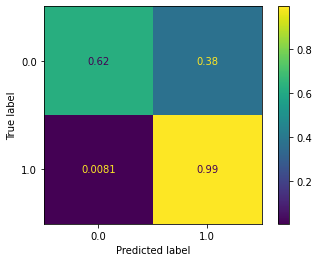

In [ ]:
# best parameters found given the intervals provided in randomSearchCV
best_params = dict(activation='tanh', alpha=0.00143, batch_size=147, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10, 10, 10), learning_rate='constant',
              learning_rate_init=0.0017000000000000001, max_fun=15000,
              max_iter=200, momentum=0.1, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=0,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)
NN.load_params(best_params)
NN.train(X_train, y_train)
print('Optimal neural network:')
NN.evaluate(X_test, y_test)

The best set of hyperparameters was found using SKLearn randomSearchCV function based on a distribution provided. The model was only able to achieve a performance of 0.81, which is comparatively lower than the other models. This is probably because the distribution intervals provided in SKLearn were not good enough. In order to produce better results, more distribution intervals needed to be tested using the same approach in order to find better hyperparameters.